In [55]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
from scipy import stats
from datetime import datetime

start = datetime.now()
matplotlib.rcParams['figure.figsize'] = (10, 7)

In [56]:
df = pd.read_parquet("car_data.parquet.gzip", use_nullable_dtypes=False)
df = df.replace({None: np.nan})
# Rename the col names to be more consistent + pythonic 
rename_dict = dict()
for col in df.columns:
    if "-" in col:
        rename_dict[col] = col.replace('-', '_')
rename_dict = {**rename_dict, **{'dellerswebsite': 'sellerwebsite'}}
df = df.rename(columns=rename_dict) 

In [57]:
print(df.shape)
df.head()

(225483, 31)


,make,model,trim,transmission,fuel_type,body_type,generation,doors,seats,mileage,...,co2Emissions,mileageDeviation,adverttitle,advert,mainimage,images,sellerpostcode,sellerwebsite,annual_tax,todaysdate
0,Daimler,Double Six,NaN,Automatic,Petrol,Saloon,NaN,4 doors,5 seats,"19,000 miles",...,NaN,NaN,Daimler Double Six 5.3 4dr,A rare and stunning example of this modern cla...,https://m.atcdn.co.uk/a/media/{resize}/70ce1ad...,https://m.atcdn.co.uk/a/media/{resize}/70ce1ad...,B93 0EF,http://www.concoursmotorco.com/,NaN,23/03/2021
1,Abarth,695,Rivale,Manual,Petrol,Hatchback,Hatchback (2014 - ),3 doors,4 seats,"17,464 miles",...,139g/km,"{'predictedMileage': 13432, 'deviation': 4032,...",Abarth 695 1.4 T-Jet Rivale 3dr,"CLICK AND COLLECT AVAILABLE, 180 Bhp VERY Limi...",https://m.atcdn.co.uk/a/media/{resize}/a29e99d...,https://m.atcdn.co.uk/a/media/{resize}/a29e99d...,SL6 4LB,http://www.alfaaid.co.uk,150.0,23/03/2021
2,Abarth,695,Biposto Record,Manual,Petrol,Hatchback,Hatchback (2014 - ),3 doors,2 seats,"8,500 miles",...,145g/km,"{'predictedMileage': 8753, 'deviation': 253, '...",Abarth 695 1.4 T-Jet Biposto Record 3dr,Our Abarth 695 Biposto Record is an exceptiona...,https://m.atcdn.co.uk/a/media/{resize}/1499516...,https://m.atcdn.co.uk/a/media/{resize}/1499516...,SY13 1LR,http://pocketrocketsales.co.uk/,165.0,23/03/2021
3,Abarth,500C,NaN,Automatic,Petrol,Convertible,Convertible (2010 - 2016),2 doors,4 seats,"17,000 miles",...,NaN,"{'predictedMileage': 28373, 'deviation': 11373...",Abarth 500C 1.4 T-Jet MTA 2dr,"Details to follow , 12 months MOT, Full servic...",https://m.atcdn.co.uk/a/media/{resize}/efe7d1e...,https://m.atcdn.co.uk/a/media/{resize}/efe7d1e...,SL6 9SN,https://dmsgateway.autotrader.co.uk/api/advert...,NaN,23/03/2021
4,Abarth,595C,Turismo,Manual,Petrol,Convertible,Convertible (2016 - ),2 doors,4 seats,"12,900 miles",...,139g/km,"{'predictedMileage': 24354, 'deviation': 11454...",Abarth 595C 1.4 T-Jet Turismo Cabrio 2dr,Awesome little rare beauty! This luxury Abarth...,https://m.atcdn.co.uk/a/media/{resize}/22f4170...,https://m.atcdn.co.uk/a/media/{resize}/22f4170...,DE1 3PA,https://dmsgateway.autotrader.co.uk/api/advert...,150.0,23/03/2021


In [58]:
features = df.columns
features

Index(['make', 'model', 'trim', 'transmission', 'fuel_type', 'body_type',
       'generation', 'doors', 'seats', 'mileage', 'emission_scheme', 'owners',
       'manufactured_year', 'engine_size', 'service_history', 'price',
       'priceindicators', 'condition', 'imported', 'year', 'vrm',
       'co2Emissions', 'mileageDeviation', 'adverttitle', 'advert',
       'mainimage', 'images', 'sellerpostcode', 'sellerwebsite', 'annual_tax',
       'todaysdate'],
      dtype='object')

### Initial Observations
- Automatic cars of the same type will likely be more expensive
- Certain body types will likely correlate to higher prices (sports car vs family saloon)
- Low mileage likely leads to increased price
- Fewer owners likely to increase pirce
- Current_date - manufactured_year = age. Newer car == more expensive
    - manufacture_year is reg, year is when the car was released?
    - Might not need the year col because the condition col is there (will need to check if they are congruent)
- ULEZ (Ultra low emmisions) might be more desirable in a city car
- Service history will need grouping. Generally, a more detailed service history = worth more money
- Condition: A new car will be more than used 
- Imported cars may be more valuable
- vrm is the reg plate. Only time this can influence price is if it is a custom reg e.g. p1lot
- Maybe can encode some of the text cols into something useful
    - Length of title? maybe shorter titles are more eye-catching
    - Maybe a longer advert = more information = more expensive
- Postcode may influence how much a car will be - more affluent areas are more likely to spend more on a car (i.e the average for a postcode in london may be higher than Stoke-on-Trent)
- Seller website column: maybe some sellers consistently list their cars for above market average (reputation etc)
- Annual tax - based on co2 emiisions. More emissions = more expensive. This col should be correlated with co2 Emissions


## Null Exploration
- 95% of the data has at least one null in a column so a naive .dropna() is not an option here.
- Imputation techniques will have to vary across columns because they are different types (categorical, discrete, continuous)
- 1/5 of the data is being dropped because of the service history column
### First Impressions for Null Imputation Strategies
- Trim -> Likely drop entire column. Trim is likely to have minimal impact
- Transmission -> "Unkown" (still only 3 categories so acceptable cardinality)
- fuel_type -> "Unknown". An Unknown fuel_type could drastically reduce price because it is am important characteristic to know before purchase
- body_type -> "Unknown". Not sure how much value a body type will add, most people do not consider it when purchasing a car, they think of other things like no. of doors
- generation -> Likely drop column because the generation of car is likely only liked to price for specific models. Bias vs Variance
- doors -> Likely correlated to the number of seats. Might be able to impute this. If seats isn't null, fill with mean number of doors for number of seats
- seats -> Likely correlated to the number of doors. Might be able to impute this. If doors isn't null, fill with mean number of seats for number of doors
- mileage -> Typically, this should be numerical so imputation is not suitable. Each car is independent so using mean, median, mode, 0, min, max would not work or make sense
- emission_scheme -> This can easily be grouped. ULEZ and N/A or Unknown
- owners -> Could be grouped as well (needs exploration) then "Unkown" could be included
- manufactured_year -> ~10% of data is null so quite high. This is reg information so likely drop this col
- engine_size -> Can be grouped again into buckets. Then null -> "Unknown"
- service_history -> Most nulls of any column. Grouped and then "Unknown"
- price_indicator -> Difficult to impute without domain knownledge. 77k rows with null so "Unknown may have to be included to avoid dropping too many cols
- year -> Nulls make it impossible to calculate age of car. Could group ages of car (< 1y/o, < 5y/o, <10/yo etc)
- vrm -> reg information probably drop. Cant impute or group
- co2Emissoons -> grouped into tax bands and then unknown

In [59]:
df.isnull().sum()

make                      0
model                     0
trim                  18115
transmission            328
fuel_type               278
body_type               503
generation             6535
doors                  1669
seats                  4848
mileage               19671
emission_scheme       49138
owners               121470
manufactured_year     19627
engine_size            6902
service_history      184317
price                     0
priceindicators       77148
condition                 0
imported                  0
year                   6638
vrm                   20350
co2Emissions          17658
mileageDeviation      40037
adverttitle               0
advert                    0
mainimage              3649
images                 3649
sellerpostcode        30103
sellerwebsite         53778
annual_tax            31300
todaysdate                0
dtype: int64

In [60]:
total_len = len(df)
non_null_len = len(df.dropna())
print(f"Amount data with at least 1 null column: {((total_len - non_null_len) / total_len) * 100:.2f}%")
print(f"Total dataset size: {total_len}")
print(f"Absolute number of rows dropped: {total_len - non_null_len}")

max_nulls = 0
col_name = ""
for k, v in dict(df.isnull().sum()).items():
    if v > max_nulls:
        max_nulls = v
        col_name = k
print(f"The column with the highest number of nulls ({max_nulls}) is {col_name}. This causes {(total_len - max_nulls) / total_len * 100:.2f}% of the data to be dropped")

Amount data with at least 1 null column: 94.85%
Total dataset size: 225483
Absolute number of rows dropped: 213873
The column with the highest number of nulls (184317) is service_history. This causes 18.26% of the data to be dropped


### Quick exploration into the target: Price
- Col will need cleaning. Currently in a string format (£17,995)
    - Remove £ and replace remove comma. Convert to int

In [61]:
def clean_target(x):
    currency_symbols = ['£', '$', '€']
    for symbol in currency_symbols:
        x = x.replace(symbol, '')
    x = x.replace(',', '')
    return int(x)
df['price'] = [clean_target(x) for x in df.price]

df.price.head()

0    17995
1    16995
2    22995
3    11995
4    11990
Name: price, dtype: int64

There is one significant outlier in this data for price
VW Transporters of this model are typically £35k - 50k so this is an obvious error and I am confident in excluding this from the dataset

If we exclude this significant outlier, the next highest price belongs to a Koenigsegg Agera. This is an extremely expensive car so this price is likely to not be an erroneous outlier.
It is still significantly higher than the average price in this dataset 

<AxesSubplot:>

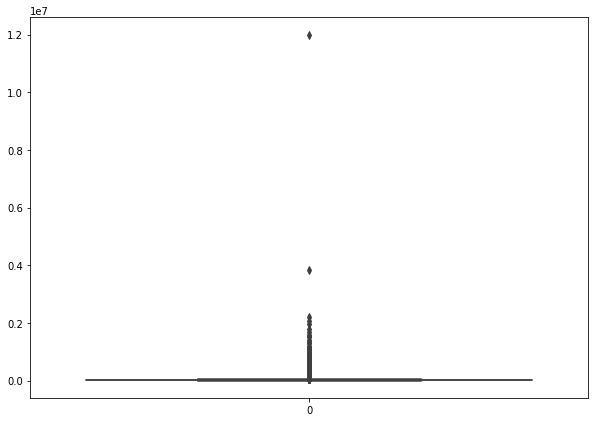

In [62]:
sns.boxplot(data=np.array(df.price))

In [63]:
df.loc[df['price'] > 0.3e7].head()

,make,model,trim,transmission,fuel_type,body_type,generation,doors,seats,mileage,...,co2Emissions,mileageDeviation,adverttitle,advert,mainimage,images,sellerpostcode,sellerwebsite,annual_tax,todaysdate
27898,Volkswagen,Transporter,Highline,Automatic,Diesel,Combi Van,Combi Van (2019 - ),5 doors,5 seats,NaN,...,NaN,NaN,Volkswagen Transporter 2.0 BiTDI T32 Highline ...,Van Haven Bespoke Transporter T32 TTR+ Exterio...,https://m.atcdn.co.uk/a/media/{resize}/4eeb612...,https://m.atcdn.co.uk/a/media/{resize}/4eeb612...,DT10 2AD,NaN,NaN,23/03/2021
40887,Koenigsegg,Agera,NaN,Automatic,Petrol,Convertible,NaN,2 doors,NaN,"6,900 miles",...,NaN,NaN,Koenigsegg Agera RSN VAT Qualifying 5.0 2dr,"Custom Josh Blue With Diamond Dust, £3,195,000",https://m.atcdn.co.uk/a/media/{resize}/fb86ce0...,https://m.atcdn.co.uk/a/media/{resize}/fb86ce0...,DE12 6JD,http://www.tomhartley.com,150.0,23/03/2021


<AxesSubplot:ylabel='Count'>

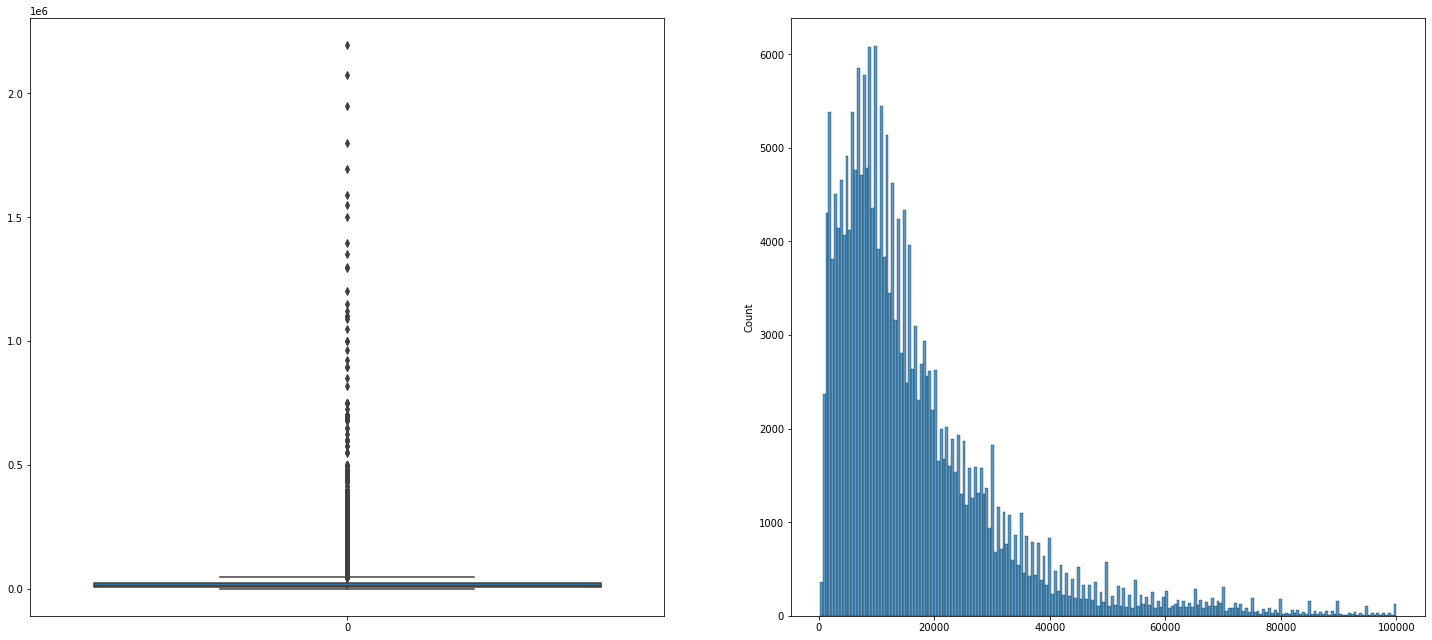

In [64]:
## Exclude extreme outliers to check distribution
fig, axes = plt.subplots(1, 2, figsize=(25, 11))
sns.boxplot(data=np.array(df['price'].loc[df['price'] < 0.35e7]), ax=axes[0]) # Exclude extreme distributions
sns.histplot(data=np.array(df['price'].loc[df['price'] <= 100000]), ax=axes[1]) # Limit to £100k (expensive car to be sold on a 'regular' website like autotrader)

#### Price Outlier Detection / Removal
##### IQR Proximity Rule
Data that falles Q1 - 1.5IQR or above Q3 + 1.5 IQR are considered outliers.  
A 1.5 multiplier is equivalent to a +- 2.7 SD which, in theory, should cover between 95% - 99% of the data

In [65]:
q3, q1 = np.percentile(df['price'], [75 ,25])
iqr_const = (q3 - q1) * 1.5
upper_bound = q3 + iqr_const
lower_bound = q1 - iqr_const
print(f"Q1: {q1}")
print(f"Q3: {q3}")
print(f"IQR: {q3 - q1}")
print(f"lower: {lower_bound}")  # This is negative which is somewhat useless (nobody would list there car for negative price)
print(f"upper: {upper_bound}")

Q1: 6995.0
Q3: 22491.0
IQR: 15496.0
lower: -16249.0
upper: 45735.0


Text(0.5, 1.0, 'Data Selected by IQR Prox Rule')

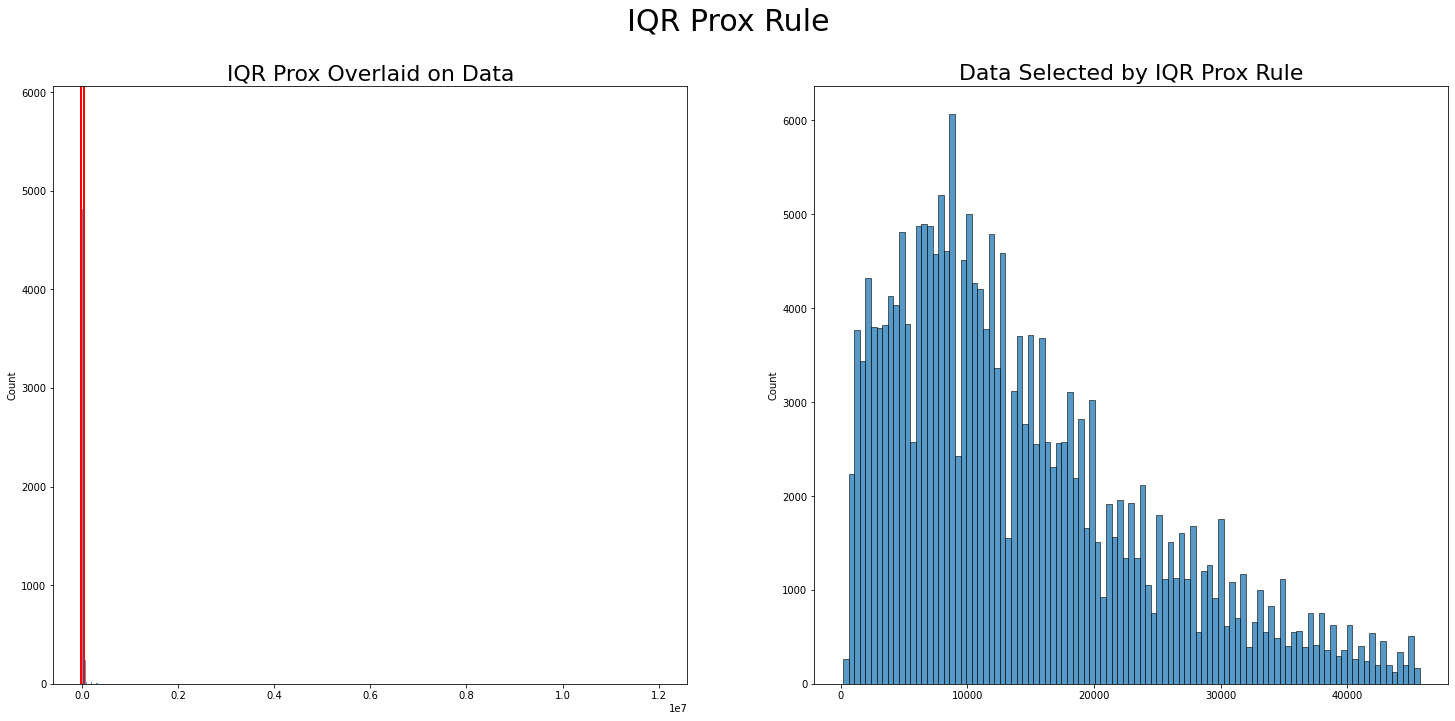

In [66]:
# fig, axes = plt.subplots(1, 2, figsize=(25, 11))
# sns.histplot(data=np.array(df['price']), ax=axes[0]) # Exclude extreme distributions
# sns.histplot(data=np.array(df['price']), ax=axes[1]) # Limit to £100k (expensive car to be sold on a 'regular' website like autotrader)
fig, axes = plt.subplots(1, 2, figsize=(25, 11))
plt.suptitle("IQR Prox Rule", fontsize=30)
# Left PLot
g1 = sns.histplot(data=np.array(df.price), ax=axes[0])
g1.set_title('IQR Prox Overlaid on Data', fontsize=22)
axes[0].axvline(lower_bound, color='red', linewidth=2)
axes[0].axvline(upper_bound, color='red', linewidth=2)

# Right Plot
mask = [False if x < lower_bound or x > upper_bound else True for x in df['price']]
df_copy = df.copy()
df_copy = df_copy[mask]
g2 = sns.histplot(data=np.array(df_copy.price), ax=axes[1])
g2.set_title('Data Selected by IQR Prox Rule', fontsize=22)

Using IQR proximity leads to removal of 14417 rows (6.4% of data). Whilst it excludes erroneous outliers such as the VW van, it also exlcudes 'actual outliers' that is, the sale of unique / desirable cars that do cost more than a typical autotrader listing

##### Explore these Outliers
- The median price of these 'outliers' is £64,844 (not uncommon for a car to cost this much) 
- The mean price is a higher £84,565 (still not that high for 'expensive' cars)



In [67]:
outlier_mask = [True if x < lower_bound or x > upper_bound else False for x in df['price']] # Reversal of previous mask
df_copy = df.copy()
df_copy = df_copy[outlier_mask]

## Roughly bin the cars on price.
# 40k - 79k. 80k - 119k. 120k - 200k. 200k +  
low = 0
med_low = 0
med_high = 0
high = 0
for i in range(len(df_copy)):
    car_price = df_copy.price.iloc[i]
    if 40000 <= car_price <= 79999:
        low += 1
    elif 80000 <= car_price <= 119999:
        med_low += 1
    elif 120000 <= car_price <= 199999:
        med_high += 1
    else:
        high += 1
df_copy_len = len(df_copy)
print(f"Low:\t\t{low}\t: {low / df_copy_len * 100:.2f}%")
print(f"Med-low:\t{med_low}\t: {med_low / df_copy_len * 100:.2f}%")
print(f"Med-High:\t{med_high}\t: {med_high / df_copy_len * 100:.2f}%")
print(f"High:\t\t{high}\t: {high / df_copy_len * 100:.2f}%")

Low:		10540	: 73.11%
Med-low:	2105	: 14.60%
Med-High:	1239	: 8.59%
High:		533	: 3.70%


Even extending the IQR proximty to include +- 3 SD (99% of data), there are still a significant number of outliers that are not actually that extreme.  
There could be a few approaches to dealing with this:
1. Have more than one model. Use them as stacked models?
    - The first prices 'average' cars which are perhaps 45K and below. Any outliers get passed to a second model
    - Second model is for 'luxury' cars that are well above average in price. E.g bugatti do not make any 'cheap' cars
2. Have a single model but significant outliers are delegated to a person for pricing
    - These extreme luxury cars are significantly less common and only a few extremely expensive cars are listed on autotrader. Downside - not fully automated
3. More domain information to create more sophisticated outlier detection
4. Use a model specifically to identify true outliers

I will explore these outlier techniques in a different notebook

In [68]:
expensive = df_copy.loc[df_copy['price'] > 199999]
expensive.head(10)

,make,model,trim,transmission,fuel_type,body_type,generation,doors,seats,mileage,...,co2Emissions,mileageDeviation,adverttitle,advert,mainimage,images,sellerpostcode,sellerwebsite,annual_tax,todaysdate
12285,Bugatti,Veyron,NaN,Automatic,Petrol,Coupe,NaN,2 doors,2 seats,"9,900 miles",...,NaN,NaN,Bugatti Veyron 8.0 2dr,"Only 9,900 miles from new, Excellent Service h...",https://m.atcdn.co.uk/a/media/{resize}/a09f4f1...,https://m.atcdn.co.uk/a/media/{resize}/a09f4f1...,TW9 4HJ,http://ddclassics.com/,NaN,23/03/2021
12286,Bugatti,Veyron,NaN,Automatic,Petrol,Coupe,NaN,2 doors,2 seats,838 miles,...,596g/km,NaN,Bugatti Veyron 8.0 2dr,Single Tone Black Metallic with Cream Leather ...,https://m.atcdn.co.uk/a/media/{resize}/44a1d0e...,https://m.atcdn.co.uk/a/media/{resize}/44a1d0e...,SM7 1AT,http://www.romansinternational.com,580.0,23/03/2021
12287,Bugatti,Veyron,NaN,Automatic,Petrol,Convertible,NaN,2 doors,NaN,"2,200 miles",...,NaN,NaN,Bugatti Veyron Grand Sport Convertible 8.0 2dr,CLICK AND COLLECT AVAILABLE Finished in White ...,https://m.atcdn.co.uk/a/media/{resize}/a016efd...,https://m.atcdn.co.uk/a/media/{resize}/a016efd...,ME5 9QG,http://www.bigmotoringworld.co.uk/autotraderve...,NaN,23/03/2021
12288,Bugatti,Veyron,NaN,Automatic,Petrol,Convertible,NaN,2 doors,NaN,"2,180 miles",...,NaN,NaN,Bugatti Veyron Grand Sport 8.0 2dr,With extremely low mileage and full H.R. Owen ...,https://m.atcdn.co.uk/a/media/{resize}/55cf397...,https://m.atcdn.co.uk/a/media/{resize}/55cf397...,W1J 6QD,https://www.hrowen.co.uk/bugatti/,NaN,23/03/2021
12289,Bugatti,Veyron,NaN,Automatic,NaN,NaN,NaN,NaN,NaN,"8,017 miles",...,NaN,NaN,Bugatti Veyron Grand Sport,1 of only 58 Veyron Grand Sports ever produced...,https://m.atcdn.co.uk/a/media/{resize}/6b8bfcc...,https://m.atcdn.co.uk/a/media/{resize}/6b8bfcc...,DE12 6BL,http://www.tomhartleyjnr.com/,NaN,23/03/2021
12290,Bugatti,Veyron,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"19,540 miles",...,NaN,NaN,Bugatti Veyron Coupe,GVE London are proud to present this Magnifice...,https://m.atcdn.co.uk/a/media/{resize}/700f439...,https://m.atcdn.co.uk/a/media/{resize}/700f439...,UB8 2DB,http://www.gvelondon.com,NaN,23/03/2021
12291,Bugatti,Veyron,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"11,756 miles",...,NaN,NaN,Bugatti Veyron 8.0,"Originally delivered new in August 2007, finis...",https://m.atcdn.co.uk/a/media/{resize}/f15f07f...,https://m.atcdn.co.uk/a/media/{resize}/f15f07f...,PR2 5BW,http://www.amarisupercars.com,NaN,23/03/2021
27898,Volkswagen,Transporter,Highline,Automatic,Diesel,Combi Van,Combi Van (2019 - ),5 doors,5 seats,NaN,...,NaN,NaN,Volkswagen Transporter 2.0 BiTDI T32 Highline ...,Van Haven Bespoke Transporter T32 TTR+ Exterio...,https://m.atcdn.co.uk/a/media/{resize}/4eeb612...,https://m.atcdn.co.uk/a/media/{resize}/4eeb612...,DT10 2AD,NaN,NaN,23/03/2021
59003,SKODA,Kodiaq,SE L,Automatic,Petrol,SUV,NaN,5 doors,NaN,NaN,...,NaN,NaN,SKODA SKODA Kodiaq KODIAQ ESTATE 1.5 TSI SE L ...,"Race Blue Metallic, £291,481",NaN,NaN,ME20 7UB,NaN,NaN,23/03/2021
67687,Rolls-Royce,Cullinan,NaN,Automatic,Petrol,SUV,SUV (2018 - ),5 doors,5 seats,"6,900 miles",...,344g/km,"{'predictedMileage': 9225, 'deviation': 2325, ...",Rolls-Royce Cullinan 5dr Auto 6.8,Rear theatre configuration with 6 disc multi-m...,https://m.atcdn.co.uk/a/media/{resize}/5287451...,https://m.atcdn.co.uk/a/media/{resize}/5287451...,SK9 3FB,http://www.sytner.co.uk/autotradervehiclelocat...,150.0,23/03/2021


##### Car Makes
- Will likely need to group rare makes. This will also handle makes that are outside this dataset coming into the model

There are 103 unique care makes


<AxesSubplot:>

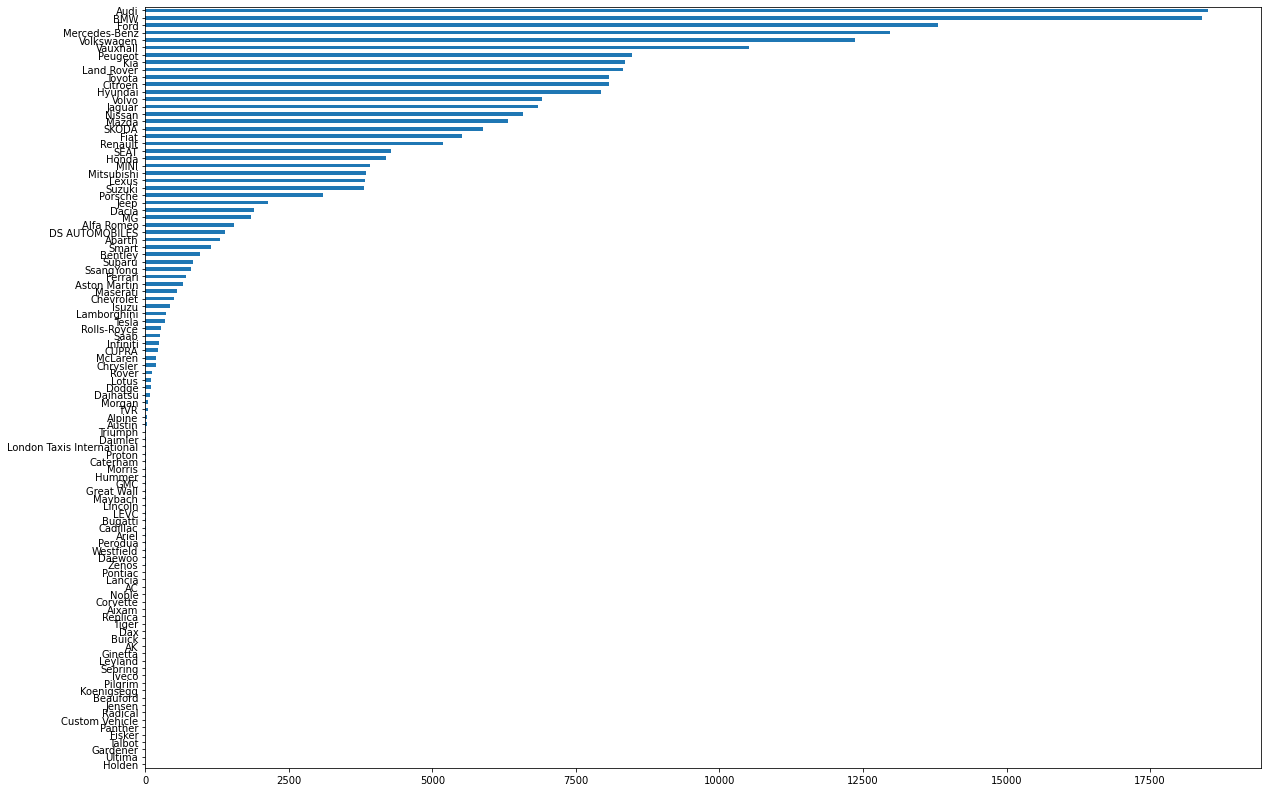

In [69]:
print(f"There are {df.make.nunique()} unique care makes")
plt.figure(figsize=(20, 14))
df.make.value_counts().sort_values().plot(kind='barh')

In [70]:
def find_rare(col, threshold=0.01):
    vcs = col.value_counts().astype(int) # This is behaving weirdly
    n = len(col)
    rare_labels = []
    for k in vcs.keys():
        vcs[k] /= n
        if vcs[k] <= threshold:
            rare_labels.append(k)
    return vcs, rare_labels

def clean_str(x):
    x = str(x).lower()
    x = re.sub(r'\W', '', x) # Symbols + whitespace
    return x

make_proportions, rare_labels = find_rare(df.make)
# df.isnull().sum()
df['make'] = ['rare' if x in rare_labels else clean_str(x) for x in df['make']]

<AxesSubplot:>

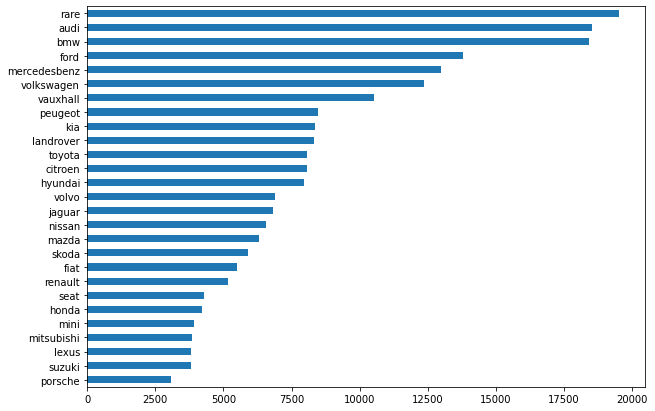

In [71]:
df.make.value_counts().sort_values().plot(kind='barh')

In [72]:
def get_ordinal(x):
    med_dict = df.groupby(x)['price'].median()
    med_dict_sorted = {k: v for k, v in sorted(med_dict.items(), key=lambda item: item[1])}
    label = 0
    for k, v in med_dict_sorted.items():
        med_dict_sorted[k] = label
        label += 1
    return med_dict_sorted
mapping = get_ordinal('make')
df['make'] = df['make'].map(mapping)

### Model
If we use the `find_rare()` function, all models will be labeled as rare because even the most popular (fiat 500) is only in 1097 rows which is less than 1% of the total length and thus will be categorised as rare  
Whilst model could be used to provide more precise predictions about price (e.g. a porsche 911 should be more than a porsche boxter), the extremely high cardinality will provide issues. Maybe could be used to squeeze some extra performance but potentially requires extensive domain knowledge.

In [73]:
print(f"There are {df.model.nunique()} unique care models")  # High cardinality
print(df.model.value_counts())


# model_proportions, model_rare_labels = find_rare(df.model)
# model_proportions
# df['model'] = ['rare' if x in model_rare_labels else x for x in df['model']]
# df.model.value_counts().sort_values().plot(kind='barh')

df.drop(columns=['model'], inplace=True)

There are 1119 unique care models
500                  1097
Outlander            1024
Focus                1009
3 Series             1007
Jazz                 1006
                     ... 
Lafesta                 1
Kallista                1
Caravan Limousine       1
Kelisa                  1
Alpina B6               1
Name: model, Length: 1119, dtype: int64


### Trim
I think Trim will be a column to drop. It might make a difference, but the difference will be small with regards to the overall price of the car. (i.e if a car costs 30k, a trim pack might add a few % on top but likely only if new)

In [74]:
df.drop(columns=['trim'], inplace=True)

### Transmission
Almost a perfect 50/50 split between manual and automatic. Could use binary encoding

Transmission appears to be a very useful feature for predicting price - even a naive conditon like 

`if auto: price * 1.5`

In [75]:
transmission_dict = dict(df.transmission.value_counts())
for k, v in transmission_dict.items():
    transmission_dict[k] /= len(df)
print(f"Manual = {transmission_dict['Manual'] * 100:.2f}% of the data\nAutomatic = {transmission_dict['Automatic'] * 100:.2f}% of the data")

def nulls(col_name):
    return df[col_name].isnull().sum()
print(f"{nulls('transmission')} rows are null")

Manual = 50.62% of the data
Automatic = 49.23% of the data
328 rows are null


In [76]:
# Mean price for different transmission types
def _extract_transmission_values(d):
    auto = d['Automatic']
    man = d['Manual']
    return int(auto), int(man)

def pct_diff(new, old):
    diff = new - old
    return round((diff / old) * 100, 2)

def get_descriptive_stats(groupby_col, target='price'): 
    auto_mean, manual_mean = _extract_transmission_values(df.groupby(groupby_col)[target].mean())
    auto_median, manual_median = _extract_transmission_values(df.groupby(groupby_col)[target].median())

    print(f"Manual Mean\t£{manual_mean}\t\tManual Median\t\t£{manual_median}")
    print(f"% Increase:\t+{ pct_diff(auto_mean, manual_mean) }%\t% Increase:\t\t+{ pct_diff(auto_median, manual_median) }%")
    print(f"Automatic Mean\t£{auto_mean}\t\tAutomatic Median\t£{auto_median}")

print("""
Both the mean and median for automatic vehicles are higher than for manual vehicles (almost double median, almost triple mean)
""")
get_descriptive_stats('transmission')

## Look into year and transmission


Both the mean and median for automatic vehicles are higher than for manual vehicles (almost double median, almost triple mean)

Manual Mean	£10457		Manual Median		£8526
% Increase:	+159.77%	% Increase:		+134.52%
Automatic Mean	£27164		Automatic Median	£19995


In [77]:
df['transmission'] = [0 if x == 'Automatic' else 1 for x in df.transmission]

### Fuel Type
There are 8 unique 'fuel types'
- Petrol
- Diesel                               
- Hybrid – Petrol/Electric
- Electric
- Hybrid – Petrol/Electric Plug-in
- Hybrid – Diesel/Electric
- Bi Fuel
- Hybrid – Diesel/Electric Plug-in

Some of these electric cars might be groupable.  
Grouping just by 'rarity' not ideal because Hybrid – Diesel/Electric appears to be, on average, more expensive than other hybrid vehicles
- Might explicitly keep Hybrid – Diesel/Electric as a group
- I think this in some ordinal encoding would work based on the median price of each fuel type

In [78]:
print(f"{nulls('fuel_type')} rows of the fuel type column are null")
print(df.fuel_type.value_counts(), end='\n\n\nMedian car Price per Fuel Type\n')

fuel_types = list(df.fuel_type.unique())
for t in fuel_types:
    mean_price_for_fuel_type = df['price'].loc[df['fuel_type'] == t].median()
    print(f"{t}:\t{mean_price_for_fuel_type}")

278 rows of the fuel type column are null
Petrol                              111417
Diesel                               93240
Hybrid – Petrol/Electric             10758
Electric                              5726
Hybrid – Petrol/Electric Plug-in      3315
Hybrid – Diesel/Electric               587
Bi Fuel                                101
Hybrid – Diesel/Electric Plug-in        61
Name: fuel_type, dtype: int64


Median car Price per Fuel Type
Petrol:	10650.0
Diesel:	12999.0
Bi Fuel:	14000.0
Hybrid – Petrol/Electric Plug-in:	29190.0
nan:	nan
Electric:	30500.0
Hybrid – Diesel/Electric:	42770.0
Hybrid – Petrol/Electric:	19459.5
Hybrid – Diesel/Electric Plug-in:	29990.0


In [79]:
df.dropna(subset=['fuel_type'], inplace=True) # Drop NA fuel_type
fuel_proportions, fuel_rare_labels = find_rare(df.fuel_type)
# print(fuel_rare_labels)

to_exclude = ["Hybrid – Diesel/Electric", "Hybrid – Diesel/Electric Plug-in"]
for exclude in to_exclude:
    fuel_rare_labels.remove(exclude)


def remove_plugin_from_fuel(x):
    x = re.sub(r'plugin', '', x)
    return x
        
df['fuel_type'] = ['other' if x in fuel_rare_labels else remove_plugin_from_fuel(clean_str(x)) for x in df.fuel_type]
print(df.fuel_type.value_counts())

petrol                  111417
diesel                   93240
hybridpetrolelectric     14073
electric                  5726
hybriddieselelectric       648
other                      101
Name: fuel_type, dtype: int64


In [80]:
## Order by median and encode 0 -> n
fuel_type_dict = dict(df.groupby('fuel_type')['price'].median())
fuel_type_dict_ordered = {k: v for k, v in sorted(fuel_type_dict.items(), key=lambda item: item[1])}
group_num = 1
for k, v in fuel_type_dict_ordered.items():
    fuel_type_dict_ordered[k] = group_num
    group_num += 1

df['fuel_type'] = df['fuel_type'].map(fuel_type_dict_ordered)

### Body Type
Doesn't appear to be any real relationship between body type and price. People don't often buy a car with a specific 'body type' in mind

In [81]:
df.drop(columns=['body_type'], inplace=True)

### Generation
Includes body style and year made. Will drop

In [82]:
df.drop(columns=['generation'], inplace=True)

### Doors + Seats
Need to do some cleaning. 4 doors -> 4. Same for seats

There is a moderate correlation between seats and doors. Could impute using this relationship - perhaps using the mode (more difficult than imagined due to edge cases in seat number)

In [83]:
def clean_doors(x):
    if isinstance(x, str):
        pattern = re.compile(r'^[0-9]*')
        x = pattern.findall(x)[0]
        return int(x)
    return x
df_local_copy = df.copy()
df_local_copy['doors'] = [clean_doors(x) for x in df_local_copy['doors']]

df_local_copy.groupby('doors')['price'].median()

doors
2.0    16750.0
3.0     5495.0
4.0    16490.0
5.0    12750.0
6.0    15250.0
Name: price, dtype: float64

In [84]:
## Exploring correlation between number of doors and number of seats
# def calc_corr_seats_doors(df):
#     df_copy = df.copy()
#     df_copy.dropna(subset=['doors'], inplace=True)
#     df_copy.dropna(subset=['seats'], inplace=True)
#     df_copy['seats'] = [clean_doors(x) for x in df_copy['seats']]
#     df_copy['doors'] = [clean_doors(x) for x in df_copy['doors']]
#     return df_copy['doors'].corr(df_copy['seats'])

# print(f"Correlation between no. seats and no. doors {calc_corr_seats_doors(df):.2f}")

# df['doors'] = [clean_doors(x) for x in df['doors']]
# df['seats'] = [clean_doors(x) for x in df['seats']]

# unique_door_numbers = [x for x in df.doors.unique() if isinstance(x, int)]
# unique_seat_numbers = [x for x in df.seats.unique() if isinstance(x, int)]

# # Impute seat number
# door_seat_dict = dict()
# seat_door_dict = dict()
# for d_number in unique_door_numbers:
#     seat_data_subset = df['seats'].loc[df['doors'] == d_number]
#     seat_number_mode = list(seat_data_subset.mode())[0]
#     door_seat_dict[d_number] = seat_number_mode


# # for s_number in unique_seat_numbers:
# #     door_data_subset = df['doors'].loc[df['seats'] == s_number]
# #     door_data_subset.head()
#     # door_number_mode = list(door_data_subset.mode())[0]
#     # seat_door_dict[s_number] = door_number_mode
# for s in unique_seat_numbers:
#     door_data_subset = df['doors'].loc[df['seats'] == s]
#     print(f"seat_num: {s}\t", list(door_data_subset.mode()))

### Doors Categorical
After an exploration into transforming doors + seats into numerical, found it was easier to keep this as a category as the cardinality is relatively low and imputation is difficult  
Now will categorise as is but include Nulls as 'unknown' and rare cases broadly as '>5 doors'

In [85]:
import category_encoders as ce

# Keep doors as categories and transform na -> unknown
df['doors'].fillna('unknown', inplace=True)
door_proportions, door_rare_labels = find_rare(df.doors)
df['doors'] = ['>5 doors' if x in door_rare_labels and x != 'unknown' else x for x in df.doors]
df.doors.value_counts()

5 doors     161339
4 doors      23362
2 doors      20453
3 doors      17301
unknown       1566
>5 doors      1184
Name: doors, dtype: int64

In [86]:
def to_binary(df, x):
    local_copy = df.copy()
    encoder = ce.BinaryEncoder(cols=[x])
    dfbin = encoder.fit_transform(local_copy[x])
    local_copy = pd.concat([df, dfbin], axis=1)
    local_copy.drop(columns=[x], inplace=True)
    return local_copy
df = to_binary(df, 'doors')

In [87]:
df.head()

,make,transmission,fuel_type,seats,mileage,emission_scheme,owners,manufactured_year,engine_size,service_history,...,advert,mainimage,images,sellerpostcode,sellerwebsite,annual_tax,todaysdate,doors_0,doors_1,doors_2
0,20,0,1,5 seats,"19,000 miles",NaN,NaN,1989 (G reg),5.3L,NaN,...,A rare and stunning example of this modern cla...,https://m.atcdn.co.uk/a/media/{resize}/70ce1ad...,https://m.atcdn.co.uk/a/media/{resize}/70ce1ad...,B93 0EF,http://www.concoursmotorco.com/,NaN,23/03/2021,0,0,1
1,20,1,1,4 seats,"17,464 miles",ULEZ,NaN,2018 (18 reg),1.4L,NaN,...,"CLICK AND COLLECT AVAILABLE, 180 Bhp VERY Limi...",https://m.atcdn.co.uk/a/media/{resize}/a29e99d...,https://m.atcdn.co.uk/a/media/{resize}/a29e99d...,SL6 4LB,http://www.alfaaid.co.uk,150.0,23/03/2021,0,1,0
2,20,1,1,2 seats,"8,500 miles",ULEZ,3 owners,2016 (66 reg),1.4L,NaN,...,Our Abarth 695 Biposto Record is an exceptiona...,https://m.atcdn.co.uk/a/media/{resize}/1499516...,https://m.atcdn.co.uk/a/media/{resize}/1499516...,SY13 1LR,http://pocketrocketsales.co.uk/,165.0,23/03/2021,0,1,0
3,20,0,1,4 seats,"17,000 miles",ULEZ,NaN,2016 (65 reg),1.4L,Full service history,...,"Details to follow , 12 months MOT, Full servic...",https://m.atcdn.co.uk/a/media/{resize}/efe7d1e...,https://m.atcdn.co.uk/a/media/{resize}/efe7d1e...,SL6 9SN,https://dmsgateway.autotrader.co.uk/api/advert...,NaN,23/03/2021,0,1,1
4,20,1,1,4 seats,"12,900 miles",ULEZ,2 owners,2016 (66 reg),1.4L,Full service history,...,Awesome little rare beauty! This luxury Abarth...,https://m.atcdn.co.uk/a/media/{resize}/22f4170...,https://m.atcdn.co.uk/a/media/{resize}/22f4170...,DE1 3PA,https://dmsgateway.autotrader.co.uk/api/advert...,150.0,23/03/2021,0,1,1


### Seats Categorical
Using my `find_rare()` function, can find what the highest number of doors is before it is under the 1% 'rare' threshold. Will then Create a new group for this  
Nulls transform to 'unknown'  
Rare transform to '>5 doors'  

In [88]:
df['seats'].fillna('unknown', inplace=True)
seat_proportions, seat_rare_labels = find_rare(df.seats)
df['seats'] = ['>6 seats' if x in seat_rare_labels and x != 'unknown' else x for x in df.seats]
df = to_binary(df, 'seats')

### Mileage
1. Transform to numerical so can explore distribution

Negative correlation ( ~ -0.3 ) between mileage and price

Grouped based on quartile

<AxesSubplot:>

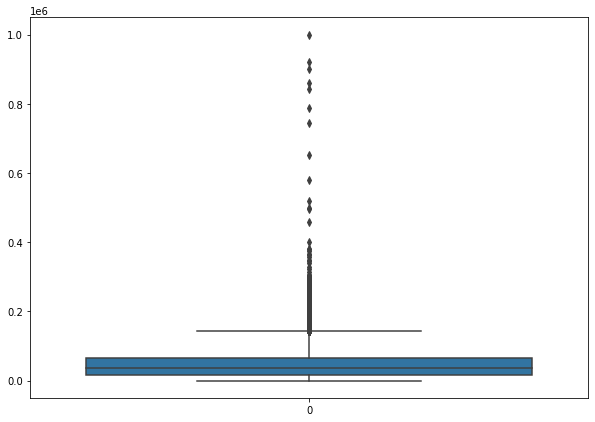

In [89]:
def extract_numerical(pattern, x):
    if isinstance(x, str):
        x = re.sub(pattern, '', x)
        x = x.replace(',', '')
        return int(x)
    return x
df_mile_copy = df.copy()
df_mile_copy['mileage'] = [extract_numerical(r'mile[s]?', x) for x in df_mile_copy['mileage']]

miles = np.array(df_mile_copy['mileage'])
sns.boxplot(data=miles)

In [90]:
# df.mileage.head()
# below_75_percentile = len(df_mile_copy.loc[df_mile_copy['mileage'] <= 66000.000000])
print(len(df_mile_copy))
df_mile_copy.dropna(subset=['mileage'], inplace=True)
print(len(df_mile_copy))
# below_75_percentile
# df_mile_copy.head(1)

225205
205582


In [91]:
def group_on_quartile(x):
    # This ordering assumes that the algo will take 0 to be more important than a larger number (i.e no1 is better than no2)
    percentile = stats.percentileofscore(df_mile_copy['mileage'], x, kind='rank')
    if percentile < 25:
        return 1
    elif 25 <= percentile < 50:
        return 2
    elif 50 <= percentile < 75:
        return 3
    else:
        return 4
df_mile_copy['mileage_quartile'] = [group_on_quartile(x) for x in df_mile_copy['mileage']]

In [92]:
df_mile_copy.groupby('mileage_quartile')['price'].median()

mileage_quartile
1    19995.0
2    13200.0
3     9995.0
4     5000.0
Name: price, dtype: float64

In [93]:
df.dropna(subset=['mileage'], inplace=True)
df['mileage'] = [extract_numerical(r'mile[s]?', x) for x in df['mileage']]
df['mileage_quartile'] = [x if isinstance(x, float) else group_on_quartile(x) for x in df['mileage']]

df.groupby('mileage_quartile')['price'].median()


mileage_quartile
1    19995.0
2    13200.0
3     9995.0
4     5000.0
Name: price, dtype: float64

### Emission Scheme
ULEZ or Unknown. Encode to binary

In [94]:
df['emission_scheme'] = [0 if x == 'ULEZ' else 1 for x in df.emission_scheme]

### Owners
There appears to be a very weak correlation between an increasing number of owners and a decreasing price  
Below figure shows that the relationship is not monotonic with an unusual spike at 11 (in the mean graph)

Will likely group into something like:  
- 1 owner
- 2 to 4 owners
- 5 to 9 owners
- 10+ owners
- unknown (for nans)

This grouping is not the most robust - if we check the mean price grouped by the above groups, the relationship is not monotonic due some clear outliers in the 10+ owners driving up the mean price. Likelwise, the mean price for null columns (which have been replaced to unknown) is also higher than 1 owner.

Because the price column is so heavily skewed, and it contains significant outliers, I chose to use the median for this purpose. Grouping by and then finding the median price produced a more expected relationship with an increase in the number of owners causing price to drop, on average. Nulls are still surprisingly high, even with the median being used.

In [95]:
df.groupby('owners')['price'].mean()

owners
1 owner      19238.671476
10 owners    16269.362069
11 owners    18811.320000
12 owners     8923.578947
13 owners     2299.375000
14 owners     5757.600000
15 owners     4847.500000
16 owners     7500.000000
17 owners     6347.000000
2 owners     13094.947155
3 owners      9999.847936
4 owners      9237.990414
5 owners      8773.076419
6 owners      9872.929412
7 owners     10818.614770
8 owners      9619.946502
9 owners     11099.163121
Name: price, dtype: float64

In [96]:
df['num_owners'] = [extract_numerical(r'owner[s]?', x) for x in df['owners']]

<AxesSubplot:xlabel='num_owners'>

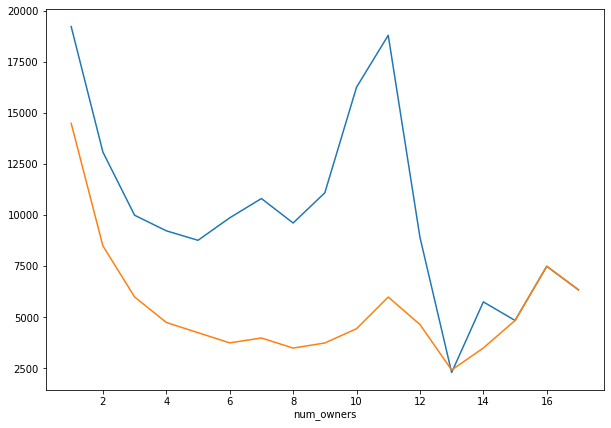

In [97]:
df.groupby('num_owners')['price'].mean().plot(kind='line')
df.groupby('num_owners')['price'].median().plot(kind='line')
# df.num_owners.corr(df.price)

In [98]:
def group_by_num_owners(x):
    try:
        x = int(x) # np.nan can't be converted to int
    except ValueError:
        return 'unknown'
    if x == 1:
        return '1 owner'
    elif 2 <= x <= 4:
        return '2to4 owners'
    elif 5 <= x <= 9:
        return '5to9 owners'
    else:
        return '10+ owners'
    
df['owners_grouped'] = [group_by_num_owners(x) for x in df['num_owners']]

In [99]:
df.groupby('owners_grouped')['price'].median()

owners_grouped
1 owner        14499.0
10+ owners      4247.5
2to4 owners     7250.0
5to9 owners     3995.0
unknown        12950.5
Name: price, dtype: float64

In [100]:
# Base N encoding of owners grouped

def to_base_n(df, x, n=4, drop=True):
    local_copy = df.copy()
    encoder = ce.BaseNEncoder(cols=[x])
    dfbin = encoder.fit_transform(local_copy[x])
    local_copy = pd.concat([df, dfbin], axis=1)
    if drop:
        local_copy.drop(columns=[x], inplace=True)
    return local_copy

df = to_base_n(df, 'owners_grouped')
df.drop(columns=['num_owners'], inplace=True)

### Manufactured Year
Contains the reg information. Potentially could influence price if a buyer really desires the 'latest' reg plate but this could also be derived from the age of the vehicle i.e buying the latest model new. Will drop col for now

In [101]:
df.drop(columns=['manufactured_year'], inplace=True)

### Engine size
Typically, a larger engine will be in more expensive cars. If you buy an affordable car, fuel efficiency is important for cost cutting. Big engines are often quite thirsty

There is one clear outlier for engine size - 3498.0L - this will be an error as it belongs to a Nissan Highway Star. Might drop this row or make a cleaning function that has a size limit in L; anything over this limit will be imputed with an 'unknown'. Over 15L

Look into L to CC conversion

In [104]:
def engine_to_numerical(x):
    try:
        x = x[:-1]
        return float(x)
    except:
        return x

df['engine_numerical'] = [engine_to_numerical(x) for x in df.engine_size]

def group_engine_size(x):
    if x <= 1.0:
        return 'small'
    elif 1.0 < x < 3.0:
        return 'medium'
    elif 3.0 <= x < 15.0:
        return 'large'
    elif 15.0 < x < 500: # Assume error in input
        x /= 10
        return group_engine_size(x)
    elif x >= 500: # Assume engine is in CC
        x /= 1000
        return group_engine_size(x)
    else:
        return 'unknown'
    
df['engine_size_numerical'] = [engine_to_numerical(x) for x in df.engine_size]
df['engine_size_grouped'] = [group_engine_size(x) for x in df.engine_size_numerical]

In [108]:
df['engine_size_grouped'].unique()

array(['large', 'medium', 'small', 'unknown'], dtype=object)

In [106]:
df.groupby('engine_size_grouped')['price'].median()

engine_size_grouped
large      28989.0
medium     10595.0
small       8190.0
unknown    23895.0
Name: price, dtype: float64

In [49]:
# Base n encoding of grouped engine size. Will use n=4 which is equivalent to ordinal encoding
df = to_base_n(df, 'engine_size_grouped', n=4, drop=False)
df.drop(columns=['engine_size'], inplace=True)
df.drop(columns=['engine_size_numerical'], inplace=True)

### Service History
Need additional domain knowledge to accurately group these. A 'full' service history should increase the price of a vehicle but there are a number of simlar groups and a very large number of nulls. Will drop

In [50]:
df.drop(columns=['service_history'], inplace=True)

### Price indicators
These show how accurate the listed price is compared the average for that model. The aim of this model is to predict price, rather than predict price at a given 'price indicator'. I.e. not only can the model accurately predict the price of a car, but it could also price is tactically to be above average for a good example and below average to make the car sell faster.

This would take more specific domain knowledge as to how these price indicators are allocated. 

In [51]:
df[['make', 'price', 'priceindicators']].head()

,make,price,priceindicators
0,20,17995,NaN
1,20,16995,"{'rating': 'FAIR', 'ratingLabel': 'Fair price'}"
2,20,22995,"{'rating': 'GREAT', 'ratingLabel': 'Great price'}"
3,20,11995,"{'rating': 'FAIR', 'ratingLabel': 'Fair price'}"
4,20,11990,"{'rating': 'LOW', 'ratingLabel': 'Lower price'}"


### Condition
Condition is one of the most straightforward columns to handle. Only 2 groups and a clear distinction between the price of new and used cars. Could be binary encoded. New = 0, used = 1

In [52]:
df.groupby('condition')['price'].median()

condition
Used    11500.0
Name: price, dtype: float64

In [53]:
df['condition'] = [0 if x == 'New' else 1 for x in df.condition]

### Imported
Bool with no nulls. Interestingly when looking at the mean, the imported cars have a higher average price. When using the median, however, price of imported cars on average is lower than non-imported vehicles.
Difficult to establish a relationship because the number of imported cars is so small. 1350 / 225,205 = 0.6% of the data

I have encoded True as 0 and False as 1 (bit confusing)

In [54]:
print(df.groupby('imported')['price'].mean())
print(df.imported.value_counts()[True] / len(df) * 100)

imported
False    16939.930497
True     25176.639673
Name: price, dtype: float64
0.6547265811209153


In [55]:
df['imported'] = [1 if not x else 0 for x in df.imported]

### Year
Will be able to engineer vehicle age from this column and todaysdate column

In [56]:
# print(df.year.head())
year_of_scrape = 2021.0
df['vehicle_age'] = [year_of_scrape - x for x in df.year]
# Classic Flag

<AxesSubplot:xlabel='vehicle_age'>

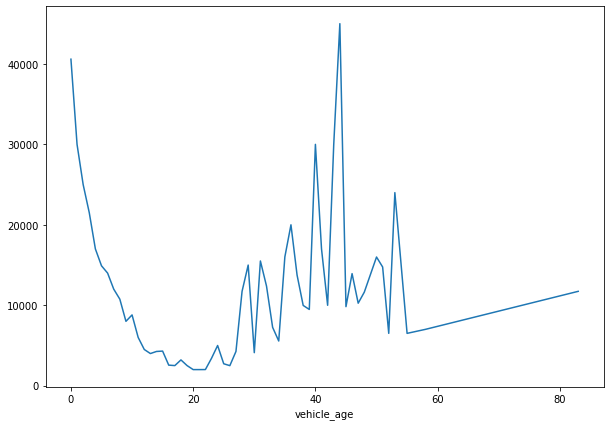

In [57]:
df.groupby('vehicle_age')['price'].median().plot(kind='line')


In [58]:
# Drop cols where vehicle age is unknown
df = df.dropna(subset=['vehicle_age'])

### VRM - Reg plate
Very specific information so no clear way to group or transform this col. Will drop for now

In [59]:
df.drop(columns=['vrm'], inplace=True)

### CO2 Emissions
Will try grouping this into tax bands
|   CO2 Emissions   
| ----------------- |
| 0 | 
| 1 to 50 |
| 51 to 75 |
| 76 to 90 |
| 91 to 100 |
| 101 to 110 |
| 111 to 130 |
| 131 to 150 |
| 151 to 170 |
| 171 to 190 |
| 191 to 225 |
| 226 to 255 |
| Over 255 |

Interestingly, cars in low tax bands are expensive (probably new electric cars) as well as the higher tax bands (large engines / performance engines). Will likely drop this column

In [60]:
def co2_to_numerical(x):
    if isinstance(x, str):
        return int(x[:-4])
    else:
        return x
def co2_grouped(x):
    if x == np.nan:
        return 'unknown'
    elif x == 0:
        return 'band1'
    elif 1 <= x <= 50:
        return 'band2'
    elif 51 <= x <= 75:
        return 'band3'
    elif 76 <= x <= 90:
        return 'band4'
    elif 91 <= x <= 100:
        return 'band5'
    elif 101 <= x <= 110:
        return 'band6'
    elif 111 <= x <= 130:
        return 'band7'
    elif 131 <= x <= 150:
        return 'band8'
    elif 151 <= x <= 170:
        return 'band9'
    elif 171 <= x <= 190:
        return 'band10'
    elif 191 <= x <= 225:
        return 'band11'
    elif 226 <= x <= 255:
        return 'band12'
    else:
        return 'band13'

In [61]:
df['co2_numerical'] = [co2_to_numerical(x) for x in df.co2Emissions]
df['co2_grouped'] = [co2_grouped(x) for x in df.co2_numerical]

In [62]:
df.groupby('co2_grouped')['price'].mean()

co2_grouped
band1     33228.426291
band10    20139.177179
band11    24334.333724
band12    30116.450695
band13    47971.584806
band2     23633.891936
band3     32617.979938
band4     12353.042877
band5      7425.986678
band6      9202.283430
band7     11299.342731
band8     12612.159153
band9     15452.445246
Name: price, dtype: float64

In [63]:
df.drop(columns=['co2Emissions'], inplace=True)
df.drop(columns=['co2_numerical'], inplace=True)
df.drop(columns=['co2_grouped'], inplace=True)

### Mileage Deviation
Mileage deviation is the deviation in mileage above or below what is expected for a particular vehicle. Difficult to impute this column without further domain knowledge.

 Might use a simple encoding. -1 if deviation is below expected, 0 is equal or unknown, 1 if deviation is above expected

In [64]:
def encode_mileage_deviation(x):
    if isinstance(x, str):
        if 'ABOVE' in x:
            return 1
        elif 'EQUAL' in x:
            return 0
        elif 'BELOW' in x:
            return -1
    return 0

df['mileageDeviation'] = [encode_mileage_deviation(x) for x in df.mileageDeviation]


### Advert Title, Advert, Main image, Images
These are all extremely difficult columns to encode, especially the images as they are just URLs

#### Advert text and title
As a bit of fun, I have used a VADER sentiment analyser to get high level groupings of [Negative, Positive, Neutral]. We can see often a neutral sentiment for both the title and the main body of the advery appears to achieve a higher mean price. When we look at the median price, again a positive and negative sentiment does not impact the price greatly, however, a neutral sentiment once again has a higher price on average

#### Images
I might try to see if there is a link between price and the number of images on the advert. Often, an item with more images can achieve a higher price because the buyer is able to get a better idea of the condion of vehicle.

Will drop all of these columns

In [65]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sid_obj = SentimentIntensityAnalyzer()

def get_sentiment(text, sid_obj):
    if isinstance(text, float):
        text = ""

    sentiment_dict = sid_obj.polarity_scores(text)

    compound = sentiment_dict['compound']
    if compound >= 0.05:
        return 1
    elif compound <= -0.05:
        return -1
    else:
        return 0

In [66]:
# df['title_sentiment'] = [get_sentiment(x, sid_obj) for x in df.adverttitle]

In [67]:
# Takes about 7 mins
# df['advert_sentiment'] = [get_sentiment(x, sid_obj) for x in df.advert]

In [68]:
# print(df.groupby('title_sentiment')['price'].median())
# print(df.groupby('advert_sentiment')['price'].median())

In [69]:
# Engineering feature related to the number of images on an advert
df['image_count'] = [x.count('https') if isinstance(x, str) else 0 for x in df.images]

In [70]:
df.groupby('image_count')['price'].median()

image_count
0      12995.0
1      12490.0
2      10990.0
3       8797.5
4       8990.0
        ...   
96     18882.0
97     14380.0
98     15995.0
99     17990.0
100    15995.0
Name: price, Length: 101, dtype: float64

In [71]:
df.drop(columns=['adverttitle'], inplace=True)
df.drop(columns=['advert'], inplace=True)
df.drop(columns=['mainimage'], inplace=True)
df.drop(columns=['images'], inplace=True)
df.drop(columns=['image_count'], inplace=True)
try:
    df.drop(columns=['title_sentiment'], inplace=True)
except:
    pass
try:
    df.drop(columns=['advert_sentiment'], inplace=True)
except:
    pass


### Seller Postcode
Likely certain postcodes will on average have higher priced cars (london vs edinburgh)  
No way to impute this

#### Haversine Formula - https://en.wikipedia.org/wiki/Haversine_formula
Using this stackoverflow post - https://datascience.stackexchange.com/questions/49553/combining-latitude-longitude-position-into-single-feature - whilst not ideal, there are some ways to combine lat and long into a single feature. At a high level it is the distance between 2 points over a spherical surface


There doesn't appear to be any strong relationsjip between any geographical information and the price of the car. 

I have tried to encode some geo information (lat and long) into a single feature, however, this does not handle the nulls (about 13% of data)

In [72]:
import pgeocode

nomi = pgeocode.Nominatim('gb')
postcodes = list(df.sellerpostcode)
geo_df = nomi.query_postal_code(postcodes)

In [73]:
print(geo_df.head(5))
print(df.sellerpostcode.isnull().sum() / len(df))


  postal_code country_code                                         place_name  \
0         SL6           GB  Taplow, Hurley Bottom, Littlewick Green, Holyp...   
1        SY13           GB  Tilstock, Bronington, Arowry, Wilkesley, The C...   
2         SL6           GB  Taplow, Hurley Bottom, Littlewick Green, Holyp...   
3         DE1           GB                                              Derby   
4        DE14           GB                        Burton upon Trent, Branston   

  state_name state_code      county_name county_code community_name  \
0    England        ENG  Buckinghamshire    11609028            NaN   
1    England        ENG       Shropshire    11609013            NaN   
2    England        ENG  Buckinghamshire    11609028            NaN   
3    England        ENG       Derbyshire    11609031            NaN   
4    England        ENG    Staffordshire    11609018            NaN   

  community_code  latitude  longitude  accuracy  
0            NaN   51.5330  -0.72959

In [74]:
df['county_name'] = geo_df['county_name']
df['state_name'] = geo_df['state_name']
df['latitude'] = geo_df['latitude']
df['longitude'] = geo_df['longitude']

In [75]:
df.groupby('state_name')['price'].mean()

state_name
England             16524.824332
Northern Ireland    16940.804262
Scotland            16868.375075
Wales               16094.326772
Name: price, dtype: float64

In [76]:
from math import radians, cos, sin, asin, sqrt

def single_pt_haversine(lat, lng, decimal_degrees=True):
    """
    'Single-point' Haversine: Calculates the great circle distance
    between a point on Earth and the (0, 0) lat-long coordinate
    """
    r = 6371 # Earth's radius (km). Have r = 3956 if you want miles

    # Convert decimal degrees to radians
    if decimal_degrees:
        lat, lng = map(radians, [lat, lng])

    # 'Single-point' Haversine formula
    a = sin(lat/2)**2 + cos(lat) * sin(lng/2)**2
    d = 2 * r * asin(sqrt(a)) 

    return d

In [77]:
df['lon_lat_feature'] = [single_pt_haversine(lat, long, decimal_degrees=True) for long, lat in zip(df.longitude, df.latitude)]
print(df['lon_lat_feature'].corr(df.price))

-0.002395622355786255


In [78]:
df.drop(columns=['county_name'], inplace=True)
df.drop(columns=['state_name'], inplace=True)
df.drop(columns=['latitude'], inplace=True)
df.drop(columns=['longitude'], inplace=True)
df.drop(columns=['sellerpostcode'], inplace=True)

### Seller website
Drop this column for now

In [79]:
df.drop(columns=['sellerwebsite'], inplace=True)

### Annual tax

<AxesSubplot:>

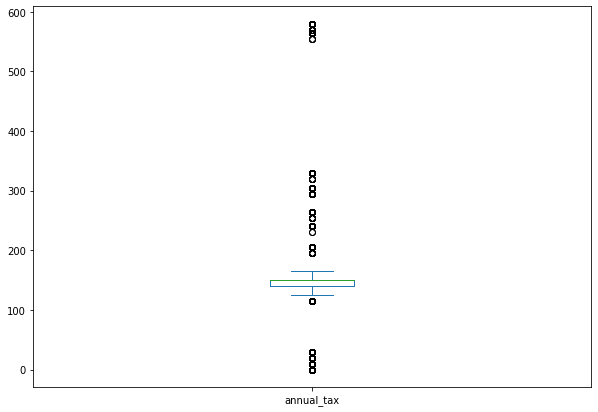

In [80]:
df.annual_tax.plot(kind='box')

In [81]:
engine_tax_dict = dict(df.groupby('engine_size_grouped')['annual_tax'].mean())
mask = df['annual_tax'].isnull()
df.loc[mask, 'annual_tax'] = df.loc[mask, 'engine_size_grouped'].map(engine_tax_dict)

In [82]:
def tax_group_on_quartile(x):
    # This ordering assumes that the algo will take 0 to be more important than a larger number (i.e no1 is better than no2)
    percentile = stats.percentileofscore(df.annual_tax, x, kind='rank')
    if percentile < 25:
        return 1
    elif 25 <= percentile < 50:
        return 2
    elif 50 <= percentile < 75:
        return 3
    else:
        return 4

df['annual_tax'] = [tax_group_on_quartile(x) for x in df.annual_tax]

In [83]:
df['annual_tax'].head()

1    3
2    4
3    2
4    3
5    3
Name: annual_tax, dtype: int64

In [84]:
df.groupby('annual_tax')['price'].mean()

annual_tax
1    11804.110306
2    15133.026329
3    20373.330632
4    14992.298740
Name: price, dtype: float64

In [85]:
df.head()

,make,transmission,fuel_type,mileage,emission_scheme,owners,price,priceindicators,condition,imported,...,mileage_quartile,owners_grouped_0,owners_grouped_1,owners_grouped_2,engine_size_grouped,engine_size_grouped_0,engine_size_grouped_1,engine_size_grouped_2,vehicle_age,lon_lat_feature
1,20,1,1,17464,0,NaN,16995,"{'rating': 'FAIR', 'ratingLabel': 'Fair price'}",1,1,...,2,0,0,1,medium,0,1,0,7.0,5891.412663
2,20,1,1,8500,0,3 owners,22995,"{'rating': 'GREAT', 'ratingLabel': 'Great price'}",1,1,...,1,0,1,0,medium,0,1,0,7.0,5730.618520
3,20,0,1,17000,0,NaN,11995,"{'rating': 'FAIR', 'ratingLabel': 'Fair price'}",1,1,...,2,0,0,1,medium,0,1,0,11.0,5886.345407
4,20,1,1,12900,0,2 owners,11990,"{'rating': 'LOW', 'ratingLabel': 'Lower price'}",1,1,...,1,0,1,0,medium,0,1,0,5.0,5873.919489
5,20,1,1,22218,0,NaN,10300,"{'rating': 'GOOD', 'ratingLabel': 'Good price'}",1,1,...,2,0,0,1,medium,0,1,0,9.0,5711.397563


In [86]:
# Dropping cols
# df.drop(columns=['owners'], inplace=True)
cols_to_drop = ['year', 'todaysdate', 'owners', 'priceindicators', 'engine_size_grouped', 'mileage', 'lon_lat_feature']
df.drop(columns=cols_to_drop, inplace=True)
# df.drop(columns=['year'], inplace=True)
# df.drop(columns=['todaysdate'], inplace=True)
# df.drop(columns=['owners'], inplace=True)
# df.drop(columns=['num_owners'], inplace=True)
# df.drop(columns=['priceindicators'], inplace=True)

In [87]:
df.head()

,make,transmission,fuel_type,emission_scheme,price,condition,imported,mileageDeviation,annual_tax,doors_0,...,seats_1,seats_2,mileage_quartile,owners_grouped_0,owners_grouped_1,owners_grouped_2,engine_size_grouped_0,engine_size_grouped_1,engine_size_grouped_2,vehicle_age
1,20,1,1,0,16995,1,1,1,3,0,...,1,0,2,0,0,1,0,1,0,7.0
2,20,1,1,0,22995,1,1,-1,4,0,...,1,1,1,0,1,0,0,1,0,7.0
3,20,0,1,0,11995,1,1,-1,2,0,...,1,0,2,0,0,1,0,1,0,11.0
4,20,1,1,0,11990,1,1,-1,3,0,...,1,0,1,0,1,0,0,1,0,5.0
5,20,1,1,0,10300,1,1,-1,3,0,...,1,0,2,0,0,1,0,1,0,9.0


In [88]:
end = datetime.now() - start
print(end)

0:03:14.567052


In [89]:
len(df)

200237